In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

## Fonction utile

Une fonction de normalisation entre 0 et 1.

In [38]:
def normalisation(X):
    """
    Fonction normalisant une matrice.

    :param X: Matrice à normaliser.
    :return: Matrice normalisée.
    """
    minX = np.min(X)
    maxX = np.max(X)

    return (X - minX)/(maxX - minX)

## Paramères utils

Création d'une classe contenant des paramètres utils à l'entrainement de l'autoencodeur

In [39]:
class config:
    batch_size=10
    learning_rate=1e-3
    epochs=50

## Création de la classe Dataset

In [40]:
class CustomDataset(Dataset):
    def __init__(self, clean_data, noisy_data):
        self.clean = clean_data
        self.noisy = noisy_data

    def __len__(self):
        return len(self.clean)

    def __getitem__(self, index):
        clean = normalisation(self.clean[index, :])
        dirty = normalisation(self.noisy[index, :])

        clean_tensor = torch.from_numpy(clean)
        noisy_tensor = torch.from_numpy(dirty)

        clean_tensor = clean_tensor.view(1, -1).type(torch.FloatTensor)
        noisy_tensor = noisy_tensor.view(1, -1).type(torch.FloatTensor)

        return noisy_tensor, clean_tensor

## Création des Dataloader

Les Dataloaders permettant d'avoir accès aux données pour l'entrainement et le test.

In [41]:
clean = pd.read_csv('label1f.csv').to_numpy()
noisy = pd.read_csv('train1f.csv').to_numpy()

training_dataset = CustomDataset(clean[:900], noisy[:900])
test_dataset = CustomDataset(clean[900:], noisy[900:])

trainloader = DataLoader(training_dataset, batch_size=config.batch_size)
testloader = DataLoader(test_dataset, batch_size=1)

## Création de l'Autoancodeur de Débruitage

La classe contient différents encodeurs et décodeurs qui peuvent être utilisés en modifiant la fonction forward

In [42]:
class DAEsignaux(nn.Module):
    def __init__(self):
        super().__init__()

        # Encodeur et décodeur à base de couches de Convolution 1D
        self.encoderConv1D = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(True),
        )
        self.decoderConv1D = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=32, out_channels=64, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=64, out_channels=128, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=128, out_channels=1, padding=1, kernel_size=3),
            nn.Sigmoid(),
        )

        # Encodeur et décodeur à base de couches Denses
        self.encoderDense = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),

        )
        self.decoderDense = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 4096),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoderConv1D(x)
        x = self.decoderConv1D(x)

        return x

## Création du modèle

Le modèle est créé puis affiché dans cette section. Les variables nécessaires pour l'entrainement sont définies également.

In [43]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

# Création du modèle
model = DAEsignaux().to(device)
summary(model, (1, 4096))

# Définition de la loss et de l'optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

epochs = 50
l = len(trainloader)
losslist = list()
epochloss = 0
running_loss = 0

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 128, 4096]             512
              ReLU-2            [-1, 128, 4096]               0
         MaxPool1d-3            [-1, 128, 2048]               0
            Conv1d-4             [-1, 64, 2048]          24,640
              ReLU-5             [-1, 64, 2048]               0
         MaxPool1d-6             [-1, 64, 1024]               0
            Conv1d-7             [-1, 32, 1024]           6,176
              ReLU-8             [-1, 32, 1024]               0
         MaxPool1d-9              [-1, 32, 512]               0
           Conv1d-10              [-1, 16, 512]           1,552
             ReLU-11              [-1, 16, 512]               0
  ConvTranspose1d-12             [-1, 32, 1024]           1,568
             ReLU-13             [-1, 32, 1024]               0
  ConvTranspose1d-14             [

## Entrainement du réseau

Entering Epoch:  1


100%|██████████| 90/90 [00:00<00:00, 90.69it/s] 


======> epoch: 1/50, Loss:0.05529302358627319
Entering Epoch:  2


100%|██████████| 90/90 [00:00<00:00, 119.79it/s]


======> epoch: 2/50, Loss:0.05103031545877457
Entering Epoch:  3


100%|██████████| 90/90 [00:00<00:00, 122.37it/s]


======> epoch: 3/50, Loss:0.04793502390384674
Entering Epoch:  4


100%|██████████| 90/90 [00:00<00:00, 99.71it/s] 


======> epoch: 4/50, Loss:0.04435638710856438
Entering Epoch:  5


100%|██████████| 90/90 [00:00<00:00, 98.14it/s] 


======> epoch: 5/50, Loss:0.04083045944571495
Entering Epoch:  6


100%|██████████| 90/90 [00:00<00:00, 103.50it/s]


======> epoch: 6/50, Loss:0.038093201816082
Entering Epoch:  7


100%|██████████| 90/90 [00:00<00:00, 112.79it/s]


======> epoch: 7/50, Loss:0.03640226274728775
Entering Epoch:  8


100%|██████████| 90/90 [00:00<00:00, 127.20it/s]


======> epoch: 8/50, Loss:0.03567395359277725
Entering Epoch:  9


100%|██████████| 90/90 [00:00<00:00, 122.20it/s]


======> epoch: 9/50, Loss:0.0354686863720417
Entering Epoch:  10


100%|██████████| 90/90 [00:00<00:00, 122.63it/s]


======> epoch: 10/50, Loss:0.035294320434331894
Entering Epoch:  11


100%|██████████| 90/90 [00:00<00:00, 121.50it/s]


======> epoch: 11/50, Loss:0.03500264510512352
Entering Epoch:  12


100%|██████████| 90/90 [00:00<00:00, 123.98it/s]


======> epoch: 12/50, Loss:0.03479694202542305
Entering Epoch:  13


100%|██████████| 90/90 [00:00<00:00, 129.78it/s]


======> epoch: 13/50, Loss:0.03469805046916008
Entering Epoch:  14


100%|██████████| 90/90 [00:00<00:00, 132.70it/s]


======> epoch: 14/50, Loss:0.03452843055129051
Entering Epoch:  15


100%|██████████| 90/90 [00:00<00:00, 132.02it/s]


======> epoch: 15/50, Loss:0.03440476953983307
Entering Epoch:  16


100%|██████████| 90/90 [00:00<00:00, 125.71it/s]


======> epoch: 16/50, Loss:0.03431263193488121
Entering Epoch:  17


100%|██████████| 90/90 [00:00<00:00, 125.97it/s]


======> epoch: 17/50, Loss:0.03417819365859032
Entering Epoch:  18


100%|██████████| 90/90 [00:00<00:00, 121.31it/s]


======> epoch: 18/50, Loss:0.034128524363040924
Entering Epoch:  19


100%|██████████| 90/90 [00:00<00:00, 128.02it/s]


======> epoch: 19/50, Loss:0.03408297523856163
Entering Epoch:  20


100%|██████████| 90/90 [00:00<00:00, 128.13it/s]


======> epoch: 20/50, Loss:0.03402223810553551
Entering Epoch:  21


100%|██████████| 90/90 [00:00<00:00, 126.80it/s]


======> epoch: 21/50, Loss:0.03395521640777588
Entering Epoch:  22


100%|██████████| 90/90 [00:00<00:00, 121.61it/s]


======> epoch: 22/50, Loss:0.03387725353240967
Entering Epoch:  23


100%|██████████| 90/90 [00:00<00:00, 125.74it/s]


======> epoch: 23/50, Loss:0.03375106304883957
Entering Epoch:  24


100%|██████████| 90/90 [00:00<00:00, 128.03it/s]


======> epoch: 24/50, Loss:0.033651839941740036
Entering Epoch:  25


100%|██████████| 90/90 [00:00<00:00, 127.63it/s]


======> epoch: 25/50, Loss:0.03360879421234131
Entering Epoch:  26


100%|██████████| 90/90 [00:00<00:00, 121.69it/s]


======> epoch: 26/50, Loss:0.03348204493522644
Entering Epoch:  27


100%|██████████| 90/90 [00:00<00:00, 129.60it/s]


======> epoch: 27/50, Loss:0.033474721014499664
Entering Epoch:  28


100%|██████████| 90/90 [00:00<00:00, 124.86it/s]


======> epoch: 28/50, Loss:0.03342370688915253
Entering Epoch:  29


100%|██████████| 90/90 [00:00<00:00, 123.95it/s]


======> epoch: 29/50, Loss:0.03334389254450798
Entering Epoch:  30


100%|██████████| 90/90 [00:00<00:00, 121.91it/s]


======> epoch: 30/50, Loss:0.03322439268231392
Entering Epoch:  31


100%|██████████| 90/90 [00:00<00:00, 112.22it/s]


======> epoch: 31/50, Loss:0.03319491073489189
Entering Epoch:  32


100%|██████████| 90/90 [00:00<00:00, 120.11it/s]


======> epoch: 32/50, Loss:0.03311803564429283
Entering Epoch:  33


100%|██████████| 90/90 [00:00<00:00, 126.28it/s]


======> epoch: 33/50, Loss:0.033041249960660934
Entering Epoch:  34


100%|██████████| 90/90 [00:00<00:00, 125.30it/s]


======> epoch: 34/50, Loss:0.033020127564668655
Entering Epoch:  35


100%|██████████| 90/90 [00:00<00:00, 127.64it/s]


======> epoch: 35/50, Loss:0.0329013429582119
Entering Epoch:  36


100%|██████████| 90/90 [00:00<00:00, 127.28it/s]


======> epoch: 36/50, Loss:0.03282788023352623
Entering Epoch:  37


100%|██████████| 90/90 [00:00<00:00, 125.10it/s]


======> epoch: 37/50, Loss:0.03277650848031044
Entering Epoch:  38


100%|██████████| 90/90 [00:00<00:00, 121.58it/s]


======> epoch: 38/50, Loss:0.0327252633869648
Entering Epoch:  39


100%|██████████| 90/90 [00:00<00:00, 127.76it/s]


======> epoch: 39/50, Loss:0.032670117914676666
Entering Epoch:  40


100%|██████████| 90/90 [00:00<00:00, 127.70it/s]


======> epoch: 40/50, Loss:0.03258676454424858
Entering Epoch:  41


100%|██████████| 90/90 [00:00<00:00, 122.11it/s]


======> epoch: 41/50, Loss:0.032541897147893906
Entering Epoch:  42


100%|██████████| 90/90 [00:00<00:00, 114.79it/s]


======> epoch: 42/50, Loss:0.0324992910027504
Entering Epoch:  43


100%|██████████| 90/90 [00:00<00:00, 117.62it/s]


======> epoch: 43/50, Loss:0.03248722106218338
Entering Epoch:  44


100%|██████████| 90/90 [00:00<00:00, 115.99it/s]


======> epoch: 44/50, Loss:0.032434578984975815
Entering Epoch:  45


100%|██████████| 90/90 [00:00<00:00, 115.61it/s]


======> epoch: 45/50, Loss:0.03239841386675835
Entering Epoch:  46


100%|██████████| 90/90 [00:00<00:00, 115.56it/s]


======> epoch: 46/50, Loss:0.03233147785067558
Entering Epoch:  47


100%|██████████| 90/90 [00:00<00:00, 116.45it/s]


======> epoch: 47/50, Loss:0.032294489443302155
Entering Epoch:  48


100%|██████████| 90/90 [00:00<00:00, 114.35it/s]


======> epoch: 48/50, Loss:0.03225225582718849
Entering Epoch:  49


100%|██████████| 90/90 [00:00<00:00, 118.87it/s]


======> epoch: 49/50, Loss:0.032215651124715805
Entering Epoch:  50


100%|██████████| 90/90 [00:00<00:00, 116.92it/s]

======> epoch: 50/50, Loss:0.03217129781842232


Text(0, 0.5, 'loss')

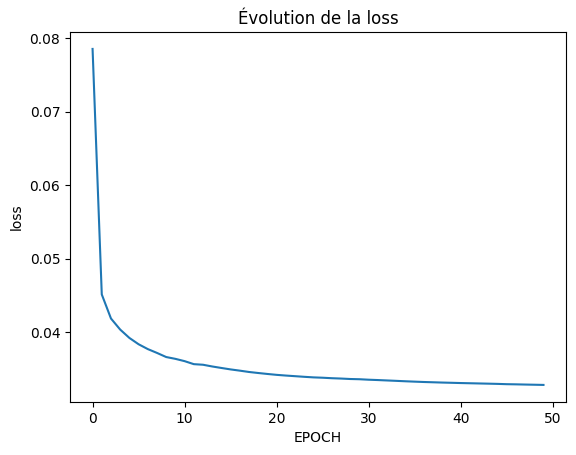

In [44]:
for epoch in range(epochs):

    print("Entering Epoch: ", epoch+1)
    for dirty, clean in tqdm((trainloader)):

        dirty, clean = dirty.to(device), clean.to(device)

        # -----------------Forward Pass----------------------
        output = model(dirty)
        loss = criterion(output, clean)
        # -----------------Backward Pass---------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epochloss += loss.item()
    # -----------------Log-------------------------------
    losslist.append(running_loss / l)
    running_loss = 0
    print("======> epoch: {}/{}, Loss:{}".format(epoch+1, epochs, loss.item()))



plt.plot(range(len(losslist)), losslist)
plt.title("Évolution de la loss")
plt.xlabel("EPOCH")
plt.ylabel("loss")

## Affichage des résultats

Les résultats de 6 éléments de la base de test sont affichés ici. La première colonne correspond au signal initial, la seconde au signal bruitée et la troisième au signal reconstruit par l'autoencodeur. La dernière colonne correspond à l'espace latent (entre l'encodeur et le décodeur).

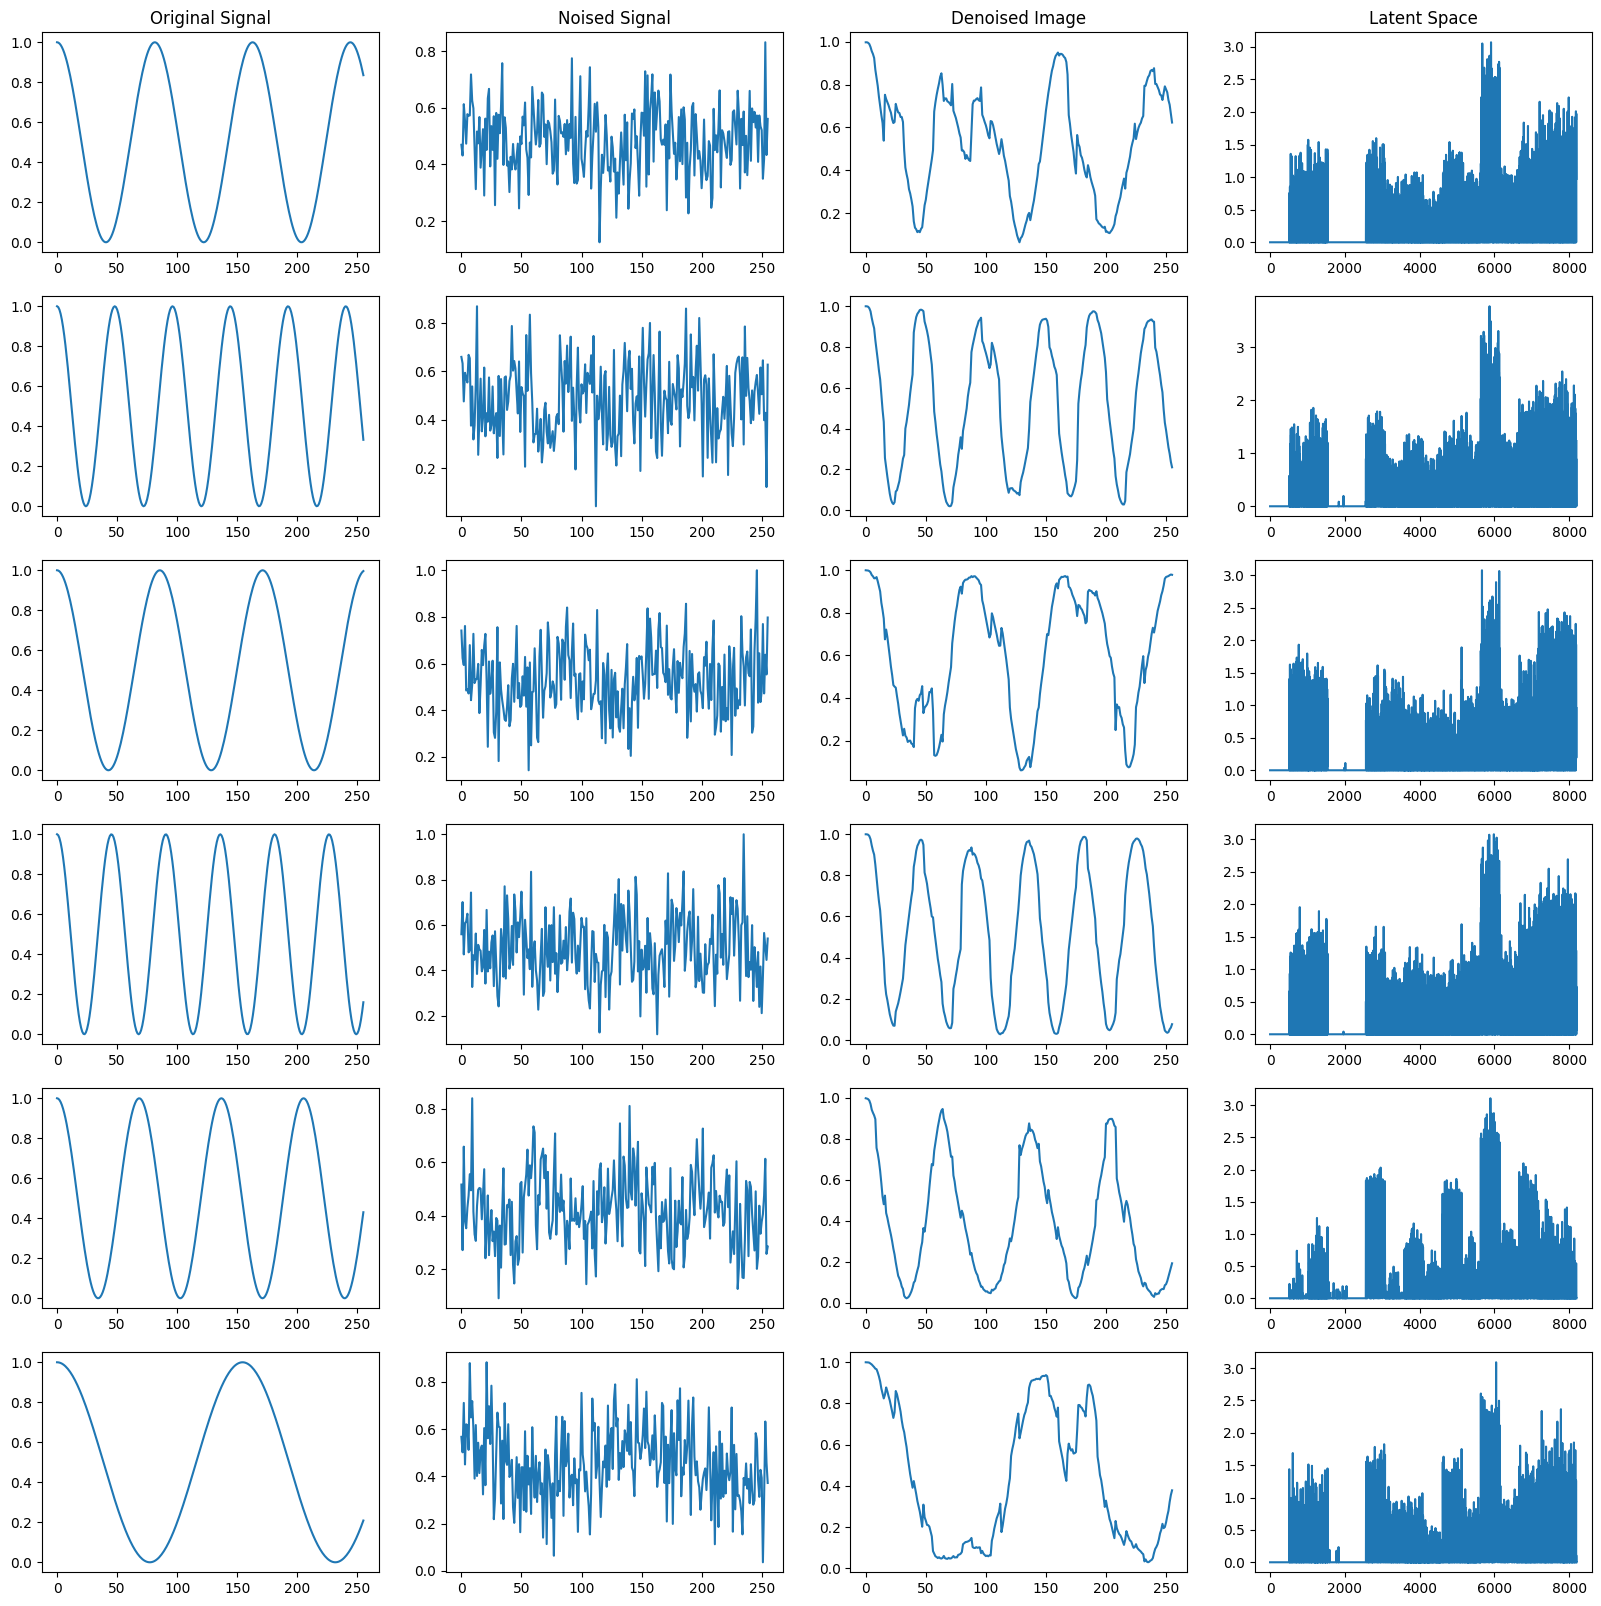

In [45]:
f, axes = plt.subplots(6, 4, figsize=(20, 20))
axes[0, 0].set_title("Original Signal")
axes[0, 1].set_title("Noised Signal")
axes[0, 2].set_title("Denoised Image")
axes[0, 3].set_title("Latent Space")

test_imgs = np.random.randint(0, 500, size=6)
i = 0
for dirty, clean in testloader:
    i+=1
    dirty = dirty.view(dirty.size(0), 1, 4096).type(torch.FloatTensor)
    dirty = dirty.to(device)

    # Encodage
    output_encoder = model.encoderConv1D(dirty)

    # Décodage
    output_decoder = model.decoderConv1D(output_encoder)

    dirty = dirty.detach().cpu().numpy()
    dirty = dirty.reshape(-1,)

    output_decoder = output_decoder.detach().cpu().numpy()
    output_decoder = output_decoder.reshape(-1,)

    clean = clean.detach().cpu().numpy()
    clean = clean.reshape(-1,)

    latent = output_encoder.detach().cpu().numpy()
    latent = latent.reshape(-1,)


    axes[i-1, 0].plot(clean[:256])
    axes[i-1, 1].plot(dirty[:256])
    axes[i-1, 2].plot(output_decoder[:256])
    axes[i-1, 3].plot(latent)

    if i == 6:
        break

plt.show()

In [46]:
PATH = "model/signauxConv1D_1f.pth"
torch.save(model.state_dict(), PATH)  # We save the model state dict at PATH